In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
#from datasets import load_dataset, load
#from huggingface_hub import hf_hub_download, snapshot_download


In [2]:
from pymicro.crystal.ebsd import OimScan
from pymicro.crystal.lattice import Lattice, CrystallinePhase, Symmetry
from pymicro.crystal.microstructure import Microstructure
import numpy as np
from pymicro.crystal.quaternion import Quaternion

In [3]:
epsilon = np.finfo('float').eps


def up_axis(axis):
    if abs(axis[2]) > epsilon:
        if axis[2] < 0.:
            # reverse axis
            return -1. * axis
    elif abs(axis[1]) > epsilon:
        if axis[1] < 0:
            # reverse axis and zero z component
            return np.array([-axis[0], -axis[1], 0.])
    elif axis[0] < 0.:
        # reverse axis and zero y and z components
        return np.array([-axis[0], 0., 0.])
    return axis




In [4]:
scan = OimScan.from_file('EBSD_rayure_anomalies/NOK_In718_ep2/In718_ep2.ctf',use_spatial_ref_frame=True )

In718_ep2 .ctf
using ref_frame 2
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
adding phase Phase 2 (Delta Ni3Nb56) 
	-- Lattice (Symmetry.orthorhombic) a=0.514, b=0.423, c=0.453 alpha=90.0, beta=90.0, gamma=90.0
x values between 0.0 419.6
y values between 0.0 899.6
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1695209/1695209 [03:13<00:00, 8755.44it/s]

In [ ]:
grains_map = scan.segment_grains(tol=5., min_ci=-0.1)

grain segmentation for EBSD scan, misorientation tolerance=5.0, minimum confidence index=-0.1, minimum grain size=0.0


In [9]:
np.save('EBSD_rayure_anomalies/NOK_In718_ep2/In718_ep2_grain_map.npy', grains_map)

In [12]:
quats = np.zeros((scan.euler.shape[0],scan.euler.shape[0],4))

In [16]:
!ls EBSD_rayure_anomalies/NOK_In718_ep2/

Band Contrast 2 Map Data 2.png In718_ep2.ctf
Euler Color 2 Map Data 2.png   Phase Color 2 Map Data 2.png
IPF X Color 2 Map Data 2.png   _epr_012_C.tif
IPF Y Color 2 Map Data 2.png   _epr_012_H.tif
IPF Z Color 2 Map Data 2.png   _epr_012_I.tif


In [4]:
grains_map = np.load('EBSD_rayure_anomalies/NOK_In718_ep2/In718_ep2_grain_map.npy')

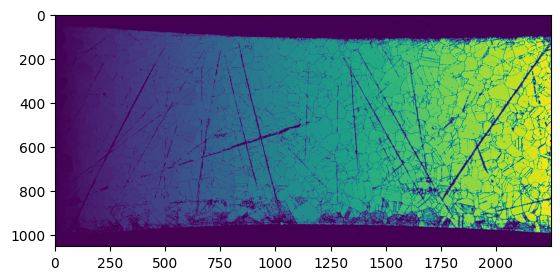

In [9]:
plt.imshow(grains_map)

In [10]:
m = Microstructure.from_ebsd('EBSD_rayure_anomalies/NOK_In718_ep2/In718_ep2.ctf',
                          grain_ids=grains_map[150:400, 0:500], roi=[150, 400, 0, 500])

0 phases found in the data set
new phase added: unknown
In718_ep2 .ctf
using ref_frame 2
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
adding phase Phase 2 (Delta Ni3Nb56) 
	-- Lattice (Symmetry.orthorhombic) a=0.514, b=0.423, c=0.453 alpha=90.0, beta=90.0, gamma=90.0
x values between 0.0 419.6
y values between 0.0 899.6
importing data from region [150, 400, 0, 500]
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 116235/116235 [00:06<00:00, 17635.78it/s]




0 phases found in the data set
new phase added: Ni-superalloy
new phase added: Delta Ni3Nb56
using existing segmentation containing 644 grains, size is  (250, 500)





creating new grains: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 644/644 [01:27<00:00,  7.39it/s]


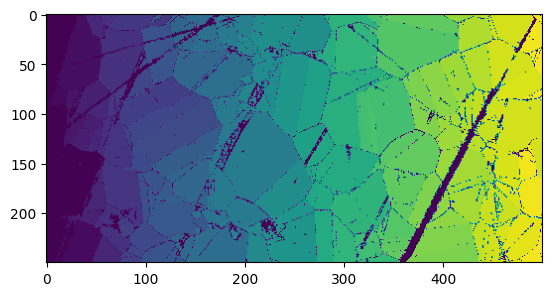

In [13]:
plt.imshow(np.squeeze(m.get_grain_map()))

In [14]:
cropped_grains_map = m.get_grain_map()

x,y = cropped_grains_map.shape[0],cropped_grains_map.shape[1]


from pymicro.crystal.microstructure import Orientation
rods = Orientation.eu2ro(m.get_field('euler').reshape((x*y, 3)))
rods = rods.reshape((x, y, 3))
m.set_orientation_map(rods)

In [35]:
quats = np.zeros((x,y,4))

In [39]:
for i in tqdm(range(x)):
    for j in range(y):
        quats[i,j,:] = Orientation.Euler2Quaternion(m.get_field('euler')[i,j,:]).quat

  0%|          | 0/250 [00:00<?, ?it/s]

In [47]:
m.dilate_grains(dilation_steps=3, new_map_name='grain_map', update_microstructure_properties=True)
grain_ids_dilated = np.squeeze(m.get_grain_map())

201 voxels to replace
dilation step 1 done
25 voxels to replace
dilation step 2 done
0 voxels to replace
dilation step 3 done



updating phase map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:01<00:00, 396.68it/s]

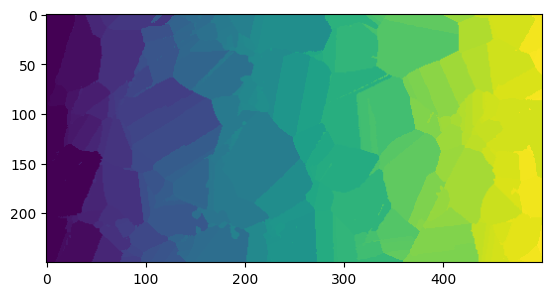

In [48]:
plt.imshow(grain_ids_dilated)

In [42]:
np.save('cropped_quats.npy', quats)

In [65]:
import numpy as np
from pymicro.crystal.microstructure import Orientation
from pymicro.crystal.lattice import Symmetry

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        # Path compression heuristic
        parent[i] = find(parent, parent[i])
        return parent[i]

def union(parent, size, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)
    
    if xroot != yroot:
        # Always attach the smaller tree to the larger tree based on size
        if size[xroot] < size[yroot]:
            parent[xroot] = yroot
            size[yroot] += size[xroot]
        else:
            parent[yroot] = xroot
            size[xroot] += size[yroot]

def merge_twins(twins_pairs, grains_ids):
    parent = {}
    size = {}

    # Extract unique grain IDs from the 2D grains_ids map
    unique_grains = np.unique(grains_ids)

    # Initialize the parent and size for each unique grain ID
    for grain_id in unique_grains:
        parent[grain_id] = grain_id
        size[grain_id] = np.sum(grains_ids == grain_id)

    # Process each twin pair and union the sets
    for grain_id, neighbor_id in twins_pairs:
        union(parent, size, grain_id, neighbor_id)

    # Create a new grains_ids map by updating each pixel to its representative
    new_grains_ids_map = np.copy(grains_ids)
    for i in range(new_grains_ids_map.shape[0]):
        for j in range(new_grains_ids_map.shape[1]):
            new_grains_ids_map[i, j] = find(parent, new_grains_ids_map[i, j])

    return new_grains_ids_map



def is_sigma_3_twin(orientation1, orientation2, crystal_structure=Symmetry.cubic):
    """Check if two orientations form a Σ3 twin relationship (60° rotation around <111> axis)."""
    sigma_3_angle = np.pi / 3  # 60 degrees in radians
    sigma_3_axis = np.array([1, 1, 1]) / np.sqrt(3)  # <111> axis

    symmetries = crystal_structure.symmetry_operators()
    gA, gB = orientation1.orientation_matrix(), orientation2.orientation_matrix()

    for g1, g2 in [(gA, gB), (gB, gA)]:
        for sym_j in symmetries:
            oj = np.dot(sym_j, g1)  # Crystal symmetry operator is left applied
            for sym_i in symmetries:
                oi = np.dot(sym_i, g2)
                delta = np.dot(oi, oj.T)
                mis_angle = Orientation.misorientation_angle_from_delta(delta)
                mis_axis = Orientation.misorientation_axis_from_delta(delta)
                if np.isclose(mis_angle, sigma_3_angle, atol=np.deg2rad(15)) and np.allclose(mis_axis, sigma_3_axis, atol=0.04):
                    return True
    return False

def are_twins(m, grain1_id, grain2_id):
    # Retrieve orientation matrices for both grains
    orientation1 = Orientation(m.get_grain(grain1_id).orientation_matrix())
    orientation2 = Orientation(m.get_grain(grain2_id).orientation_matrix())
    return is_sigma_3_twin(orientation1, orientation2)

def find_twins_and_boundaries(m, grain_ids):
    twins_pairs = []
    twins_boundaries = np.zeros_like(grain_ids, dtype=np.uint8)

    for i in tqdm(range(grain_ids.shape[0] - 1)):
        for j in range(grain_ids.shape[1] - 1):
            grain_id = grain_ids[i, j].item()  # Safely extract scalar from the array
            if grain_id != 0:
                neighbors = [(i + 1, j), (i, j + 1)]  # Check right and bottom neighbors
                for ni, nj in neighbors:
                    neighbor_id = grain_ids[ni, nj].item()  # Safely extract scalar from the array
                    if neighbor_id != 0 and neighbor_id != grain_id:
                        if are_twins(m, grain_id, neighbor_id):
                            twins_pairs.append([grain_id, neighbor_id])
                            # Mark twin boundary
                            twins_boundaries[i, j] = 1
                            twins_boundaries[ni, nj] = 1

    return twins_pairs, twins_boundaries
# Assume m (Microstructure) and grain_ids (array) are provided


# At this point, you have new_grain_ids (after twin removal) and twins_boundaries (binary map)

In [66]:
twins_pairs, twins_boundaries = find_twins_and_boundaries(m, cropped_grains_map)
new_grain_ids = merge_twins(twins_pairs, grain_ids_dilated)

  0%|          | 0/249 [00:00<?, ?it/s]

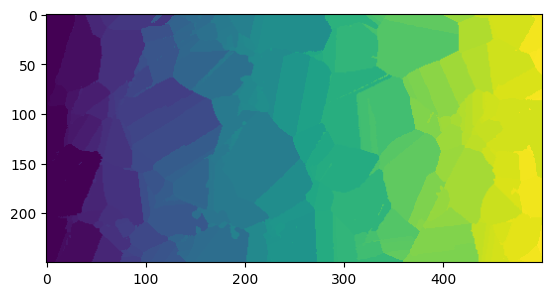

In [67]:
plt.imshow(grain_ids_dilated)

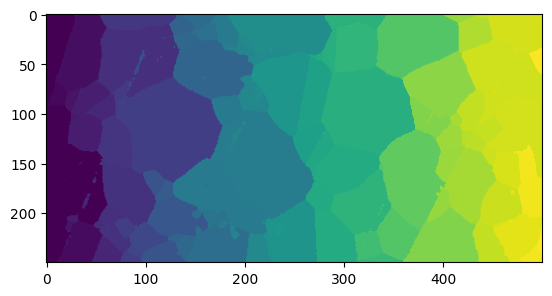

In [68]:
plt.imshow(new_grain_ids )

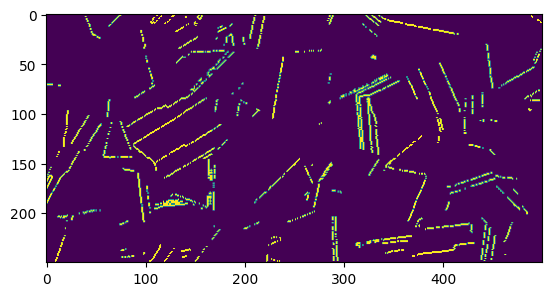

In [69]:
plt.imshow(twins_boundaries)